In [1]:
from collections import defaultdict
import os
import sys 
from tqdm import tqdm
import itertools
import utils.file_utils as utils
sys.path.append("/data/jeff-law/projects/fungcat-function-prediction/src")
#sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))))
import fungcat_settings as f_settings
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % (matplotlib.__version__))
print("pandas version: %s" % (pd.__version__))
print("seaborn version: %s" % (sns.__version__))
print("numpy version: %s" % (np.__version__))

python version: 2.7.12 (default, Nov 12 2018, 14:36:49) 
matplotlib version: 2.0.0
pandas version: 0.22.0
seaborn version: 0.7.1
numpy version: 1.14.2


/home/jeffl/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


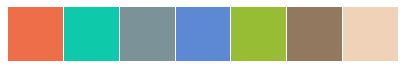

In [2]:
# tried to be fancy :P
# colors: https://coolors.co/ef6e4a-0ec9aa-7c9299-5d88d3-96bd33
my_palette = ["#EF6E4A", "#0EC9AA", "#7C9299", "#5D88D3", "#96BD33", "#937860", "#efd2b8"]
# my_palette = ["#b55d60ff", "#0EC9AA", "#7C9299", "#5D88D3", "#96BD33", "#937860", "#efd2b8"]
# my_palette_2
sns.palplot(my_palette)

In [3]:
os.chdir("../..")

In [4]:
os.getcwd()

'/data/jeff-law/projects/fungcat-function-prediction'

In [5]:
def get_results(version, exp_names, algorithms, unweighted='', 
                alpha_list=["0_8"], theta_list=[None], mu_list=[None], lambda_list=[None], tol_list=[""],
                ss_alpha="0_8", maxi_list=[], ss_maxi="eps0_0-maxi20", exp_type="ground-truth", verbose=False):
    df_all = pd.DataFrame()
    for exp_name in exp_names:
        loaded = {alg: False for alg in algorithms}
        read_files = set()
        for alg in algorithms:
            if loaded[alg] is True:
                print("Warning! %s being loaded again for %s" % (alg, exp_name))
            # load the results table
            results_dir = "outputs/%s/all/%s/%s" % (version, alg, exp_name)
#             params_list = zip(alpha_list, )
            for alpha, theta, mu, br_lambda, maxi, tol in itertools.product(*[
                alpha_list, theta_list, mu_list, lambda_list, maxi_list, tol_list]):
#                 print(alg, theta, mu)
                if tol != "":
                    # tol should only be for genemania
                    if alg != "genemania":
                        continue
                    results_file = "%s/%s%s-%sl0-a%s%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type, unweighted, alpha, maxi, tol)
                elif alg == 'birgrank' and (theta is not None and mu is not None):
                    results_file = "%s/%s%s-%sl0-a%s%s%s%s%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type,
                        "swsn-" if 'string' in version and unweighted in ["", "goterm-weight-", "gm2008-"] else unweighted, # BirgRank can't use goterm-weight, so don't include it
                        alpha, "-eps0_0001-maxi1000" if maxi != "" else "", 
                        theta, mu, br_lambda, "a0_5" if maxi == "" else "")
#                         results_dir, unweighted, alpha, theta, mu, alpha)
                elif alg == 'aptrank':
                    results_file = "%s/%s%s-%sl0-k8-s5-t0_5-%sa%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type,
                        "swsn-" if unweighted not in ["unw-"] else '', 
                        "oneway", alpha, maxi)
                else:
                    results_file = "%s/%s%s-%sl0-a%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type, unweighted, alpha, maxi)
                if verbose:
                    print("Reading results from %s" % (results_file))
                if not os.path.isfile(results_file):
                    if verbose:
                        print("\tdoesn't exist. Skipping")
                    continue
                if results_file in read_files:
                    # don't read a file twice. This happens to BirgRank if we are using multiple different max_iters
                    continue
                read_files.add(results_file)
                # results_file_template = "%s/groundtruth-l0-a0_8.txt" % (results_dir)
                df = pd.read_csv(results_file, sep='\t')
                if alg == "birgrank" and alpha == "0_9" and theta == "-t0_5" and mu == "-m0_5" and br_lambda == "-l0_01":
                    df['Algorithm'] = alg_name[alg]
                    loaded[alg] = True
                elif alg == "birgrank":
                    df['Algorithm'] = 'birgrank a%s%s%s%s' % (alpha, theta, mu, br_lambda)
#                 elif alg == "sinksource" and alpha != "1_0":
                elif alg == "sinksource" and (alpha != ss_alpha or maxi != ss_maxi):
                    df['Algorithm'] = 'sinksource a%s %s' % (alpha, maxi)
#                     print("\t keeping only alpha %s for now" % (ss_alpha))
#                     continue
                # TODO don't write the output file with an alpha value for local and localplus
                elif (alg == "local" or alg == "localplus" or alg == "sinksourceplus") and alpha not in ["0_8", "0_95"]:
                    # make sure I'm only getting the alpha 0.8 and not multiple copies of the same algorithm
                    continue
                else:
                    df['Algorithm'] = alg_name[alg]
                    if verbose:
                        print("%d sp-goterm pairs" % (len(df['Algorithm'])))
                    loaded[alg] = True

    #             print(df.head())
                # I changed '# ann' to be the more correct '# test ann', but am changing it back here to match previous files 
                if '# test ann' in df.columns:
                    df.rename(columns={'# test ann':'# ann'}, inplace=True)
                df_all = pd.concat((df_all, df))
    return df_all

In [6]:
# also read in the prots annotated to each GO term
def parse_pos_neg_file(pos_neg_file, goterms=None):
    print("Reading positive and negative annotations for each protein from %s" % (pos_neg_file))
    goid_prots = {}
    with open(pos_neg_file, 'r') as f:
        for line in f:
            if line[0] == '#':
                continue
            goid, pos_neg_assignment, prots = line.rstrip().split('\t')[:3]
            if goterms and goid not in goterms:
                continue
            prots = set(prots.split(','))
            if int(pos_neg_assignment) == 1:
                goid_prots[goid] = prots
    return goid_prots

def get_species_prot_counts(goid_prots, species_to_uniprot, selected_species=None, goids=None):
    print("Getting annotation counts per species")
    if selected_species is None:
        selected_species = species_to_uniprot.keys()
    if goids is None:
        goids = goid_prots.keys()
    species_prot_counts = {}
    for s in selected_species:
        species_prots = species_to_uniprot[str(int(s))]
        #print("species: %s, %d prots" % (s, len(species_prots)))
#         total_prots = set()
        total_ann = 0
        for goid in goids:
            if goid not in goid_prots:
                continue
            s_prots = goid_prots[goid] & species_prots
#             total_prots.update(s_prots)
            total_ann += len(s_prots)
        species_prot_counts[s] = total_ann
        
    return species_prot_counts

ev_codes = "exp"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-50-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-50-list.tsv" % (ev_codes),
]
exp_goid_prots = {}
for pos_neg_file in pos_neg_files:
    exp_goid_prots.update(parse_pos_neg_file(pos_neg_file))
    

# ev_codes = "rem-neg-iea"
ev_codes = "comp"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-5-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-5-list.tsv" % (ev_codes),
]
comp_goid_prots = {}
for pos_neg_file in pos_neg_files:
    comp_goid_prots.update(parse_pos_neg_file(pos_neg_file))

ev_codes = "iea"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-10-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-10-list.tsv" % (ev_codes),
]
iea_goid_prots = {}
for pos_neg_file in pos_neg_files:
    iea_goid_prots.update(parse_pos_neg_file(pos_neg_file))

Reading positive and negative annotations for each protein from inputs/pos-neg/exp/pos-neg-bp-50-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/exp/pos-neg-mf-50-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/comp/pos-neg-bp-5-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/comp/pos-neg-mf-5-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/iea/pos-neg-bp-10-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/iea/pos-neg-mf-10-list.tsv


In [7]:
def split_results_by_cutoffs(df_all, cutoffs, 
                             exp_goid_prots, comp_goid_prots, iea_goid_prots, 
                             overall_goid_prots=None):
    # now limit it to the current GO term split
    cutoffs_data = []
    for cutoff1, cutoff2 in cutoffs:
        print(cutoff1, cutoff2)
#         if split_by_overall_counts is True:
            # group the goids by the # of ann in all 19 species
            # this would be the # of annotations in the evaluation group
            # we want the # of annotations with the training evidence codes
            #num_ann = df_all[df_all['Algorithm'] == 'SinkSource'][['goid', '# ann']].groupby("goid").sum()
        if overall_goid_prots is not None:
            print("\tusing splits over all species")
            curr_goids = set([g for g, prots in overall_goid_prots.items() if len(prots) >= cutoff1 and len(prots) < cutoff2])
            df_curr = df_all[df_all['goid'].isin(curr_goids)]
            # also only keep those that have at least 10 in the evaluated species
            df_curr = df_curr[(df_curr['# ann'] >= 10)]
        else:
            print("\tusing splits for each individual species")
#             col = '# ann' if '# ann' in df_curr.columns else '# test ann'
            col = '# ann'
            df_curr = df_all[(df_all[col] >= cutoff1) & (df_all[col] < cutoff2)] 
        if keep_ann != '':
            # species are not split
            species_exp_counts = {}
            species_comp_counts = {}
            species_iea_counts = {}
        else:
            species_exp_counts = get_species_prot_counts(exp_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
            species_comp_counts = get_species_prot_counts(comp_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
            species_iea_counts = get_species_prot_counts(iea_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
        cutoffs_data.append((df_curr, species_exp_counts, species_comp_counts, species_iea_counts))
    return cutoffs_data

In [8]:
def plot_fmax_eval(
    cutoffs_data, cutoffs, out_dir, measure='fmax', 
    sort_taxon_by_fmax={}, write_to_file=False, ann_stats=None, for_pub=False):
    """
    *ann_stats*: Set of annotation types (either 'EXP', 'COMP' or 'IEA') for which a boxplot will be added to the right # of annotations
    *for_pub*: If true, the title at the top will not be included
    """
    for i, (cutoff1, cutoff2) in enumerate(cutoffs):
        df_curr, species_exp_counts, species_comp_counts, species_iea_counts = cutoffs_data[i]
        # add the species name to the boxplot
        species_labels = {}
        for s in df_curr['#taxon']:
#             species_labels[s] = r"\textit{%s} (%d)" % (
            # the latex isn't working
            species_labels[s] = "%s. (%d)" % (
                f_settings.NAME_TO_SHORTNAME.get(selected_species[str(s)], str(s)),  #f_settings.NAME_TO_SHORTNAME2[selected_species[str(s)]],
                df_curr[df_curr['#taxon'] == s]['goid'].nunique())
        species_labels = pd.Series(species_labels)
        df_curr['species'] = df_curr['#taxon'].apply(lambda x: species_labels[x])
        df_curr = df_curr.sort_values(by=['species', 'Algorithm'], ascending=[True, False])
        if (cutoff1, cutoff2) not in sort_taxon_by_fmax:
#             sort_by_med_fmax[(cutoff1, cutoff2)] = df_curr[df_curr['Algorithm'] == alg_name[algorithms[0]]].groupby('species')['fmax'].median().sort_values(ascending=False).index
            sort_taxon_by_fmax[(cutoff1, cutoff2)] = df_curr[df_curr['Algorithm'] == alg_name[algorithms[0]]].groupby('#taxon')['fmax'].median().sort_values(ascending=False).index
            # now get the species order from the taxon order
        df_curr['#taxon'] = df_curr['#taxon'].astype("category")
        df_curr['#taxon'].cat.set_categories(sort_taxon_by_fmax[(cutoff1, cutoff2)], inplace=True)
        sort_by_med_fmax = df_curr.sort_values(by='#taxon')['species'].unique()

        use_neg_str = "using negative examples" if with_neg != "" else ""
#         title = "Evaluation of recovery of %s ev. codes from %s ev. codes %s\n for 19 pathogenic bacteria. - %s  %s\n %d GO terms with %d <= # annotations < %d %s" % (
#             eval_ev_codes, ev_codes, use_neg_str, version, keep_ann, df_curr['goid'].nunique(), cutoff1, cutoff2, "overall" if split_overall else "")
        title = ""
        if for_pub is False:
            title = "Evaluation of recovery of %s ev. codes from %s ev. codes %s\n for 19 pathogenic bacteria. - %s  %s\n %d %s GO terms with %d+ annotations %s" % (
                eval_ev_codes, ev_codes, use_neg_str, version, keep_ann, df_curr['goid'].nunique(), h.upper(), cutoff1, "overall" if split_overall else "")
        xlabel = r'F$_{\mathrm{max}}$'
        ylabel = 'Species (# GO Terms)'
#         fig, ax = plt.subplots(figsize=(6,10))
#         fig, ax = plt.subplots(figsize=(5,6))
        if ann_stats is not None and ('COMP' in ann_stats or 'ELEC' in ann_stats):
            # make the figure taller to fit all the species
            fig, ax = plt.subplots(figsize=(3.5,8))
        else:
            fig, ax = plt.subplots(figsize=(3.5,6))
#         figsize=(8,6)
        sns.boxplot(x=measure, y='species', order=sort_by_med_fmax, 
#                     hue='Algorithm', data=df_curr, orient='h')
                   hue='Algorithm', hue_order=[alg_name[a] for a in algorithms], 
                    data=df_curr, orient='h', fliersize=1.5,
                   palette=my_palette)
        plt.title(title)
        plt.xlabel(xlabel, fontsize=12, weight="bold")
        plt.ylabel(ylabel, fontsize=12, weight="bold")
        # didn't work
#         locs, labels = plt.yticks()
#         plt.yticks(locs, [r'%s'%l for l in sort_by_med_fmax])
#         plt.legend(bbox_to_anchor=(1.2, 1.2))
        plt.legend(bbox_to_anchor=(.45, 1.0))
        ticks = np.arange(0,1.01,.1)
        plt.setp(ax, xticks=ticks, xticklabels=["%0.1f"%x for x in ticks])
        if ann_stats is not None:
            # add another plot to the right that is a bar plot of the # of non-iea (or exp) annotations
            right_ax = plt.axes([.95, .13, .2, .75])
            df_counts = pd.DataFrame()
            if 'EXP' in ann_stats:
                df_counts = pd.DataFrame([species_exp_counts]).T
                df_counts.columns = ['EXP']
            if 'COMP' in ann_stats:
                s = pd.Series(species_comp_counts)
                df_counts['COMP'] = s
            if 'ELEC' in ann_stats:
                s = pd.Series(species_iea_counts)
                df_counts['ELEC'] = s
            df_counts['#taxon'] = df_counts.index
            df_counts.index = range(len(df_counts.index))
            df_counts = pd.melt(df_counts, id_vars="#taxon", var_name="Ev. codes", value_name="# ann")
            df_counts['species'] = df_counts['#taxon'].apply(lambda x: species_labels[x])
            sns.barplot(y='species', x='# ann', hue="Ev. codes", order=list(sort_by_med_fmax), 
                        data=df_counts, orient='h', ax=right_ax, palette="OrRd_d") #palette="OrRd_d")
        #                 color=sns.color_palette()[3])
            change_width(right_ax, 0.45)
            right_ax.set_ylabel("")
            right_ax.set_xlabel("# Ann")
            right_ax.set_yticks([])

        out_file = "%s/%d-%d-%s-%s%s-%s-%sa%s%s.pdf" % (out_dir, cutoff1, cutoff2, h, len(algorithms), with_neg, measure, unweighted, ss_alpha, ss_maxi)
        if write_to_file:
            print("Writing figure to %s" % (out_file))
            plt.savefig(out_file, bbox_inches='tight')
        else:
            print("File would be written to %s" % (out_file))
        plt.show()
        plt.close()

In [9]:
# change the width of the extra bar plot to the side
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
#         print(current_width)
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5 + 0.08)

In [10]:
# also plot a histogram of all the Fmax values
# cutoff1, cutoff2 = cutoffs[0]
# df_curr = cutoffs_data[0][0]
def plot_overview(cutoffs_data, cutoffs, out_dir, measure='fmax'):
    for i, (cutoff1, cutoff2) in enumerate(cutoffs):
        df_curr, _, _, _ = cutoffs_data[i]
        use_neg_str = "using negative examples" if with_neg != "" else ""
        out_pref = "%s/%d-%d-%s-%s%s-%s-%sa%s%s" % (out_dir, cutoff1, cutoff2, h, len(algorithms), with_neg, measure, unweighted, ss_alpha, maxi)
        title = "Recovery of %s ev. codes from %s ev. codes  %s\n for 19 pathogenic bacteria. - %s \n %d GO terms with %d <= # annotations < %d" % (
            eval_ev_codes, ev_codes, use_neg_str, version, df_curr['goid'].nunique(), cutoff1, cutoff2)
        print(df_curr['Algorithm'].unique())
#         print(df_curr.head())
#         print(title)
        overview_plots(df_curr, measure, title=title, out_pref=out_pref)

def overview_plots(df, measure, title="", xlabel=r'F$_{\mathrm{max}}$', 
                   out_pref=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    # also plot a box and whisker plot of the algorithms
#     sns.factorplot(x=measure, y='Algorithm', data=df, ax=ax,
#                fliersize=1.5, order=[alg_name[a] for a in algorithms],
#                kind="box")
    sns.boxplot(x=measure, y='Algorithm', data=df, ax=ax,
               fliersize=1.5, order=[alg_name[a] for a in algorithms],
               palette=my_palette)
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax.set_ylabel("")
    ax.set_title(title, fontsize=14, fontweight='bold')    
    ax.set_xlim(-0.025, 1.025)
    ticks = np.arange(0,1.01,.1)
    # ax.set_xticks(ticks, ["%0.1f"%x for x in ticks])
    plt.setp(ax, xticks=ticks, xticklabels=["%0.1f"%x for x in ticks])
    # add the intermediate xticks
#     locs, labels = plt.xticks()
    if out_pref is not None:
        out_file = out_pref + '-boxplot.pdf'
        print("Writing %s" % (out_file))
        plt.savefig(out_file, bbox_inches='tight')
#     plt.show()
#     plt.close()

In [11]:
# also compute the significance of sinksource vs local
from scipy.stats import kruskal, mannwhitneyu
import itertools


def eval_stat_sig(cutoffs_data, cutoffs, out_dir, 
                  alg1='sinksource', alg2='localplus', measure='fmax', 
                  sort_taxon_by_fmax={}, h='', write_to_file=True):
    cutoff_sig = defaultdict(dict)    
    out_str = ""
    for i, (cutoff1, cutoff2) in enumerate(cutoffs):
        df_curr, _, _, _ = cutoffs_data[i]
        print("%d - %d annotations. Version: %s, '%s' annotations" % (cutoff1, cutoff2, version, ev_codes))

#         df_curr = df_all[(df_all['# ann'] >= cutoff1) & (df_all['# ann'] < cutoff2)]
        combinations = list(itertools.combinations(algorithms, 2))
        out_str += "#alg1\talg2\tpval\tCorrected p-value (x%d)\n" % (len(combinations))
        # Don't think sorting is needed
        df_curr.sort_values('goid', inplace=True) 
        for a1, a2 in combinations:
            a1_fmax = df_curr[df_curr['Algorithm'] == alg_name[a1]]['fmax']
            a2_fmax = df_curr[df_curr['Algorithm'] == alg_name[a2]]['fmax']
            test_statistic, pval = mannwhitneyu(a1_fmax, a2_fmax, alternative='greater') 
            out_str += "%s\t%s\t%0.3e\t%0.3e\n" % (a1, a2, pval, pval*len(combinations))

        # also compare individual species
    #     for a1, a2 in itertools.combinations(algorithms, 2):
#         a1 = "sinksource"
#         a2 = "localplus"

        curr_species = df_curr['#taxon'].unique()
        if (cutoff1, cutoff2) in sort_taxon_by_fmax:
            curr_species = sort_taxon_by_fmax[(cutoff1, cutoff2)]
        out_str += "Species\tAlg1\tAlg2\tRaw p-value\tCorrected p-value (x%d)\n" % (len(curr_species))
        for s in curr_species:
            name = f_settings.NAME_TO_SHORTNAME2.get(selected_species[str(s)],'-')
            df_s = df_curr[df_curr['#taxon'] == s]
            a1_fmax = df_s[df_s['Algorithm'] == alg_name.get(alg1, alg1)][measure]
            a2_fmax = df_s[df_s['Algorithm'] == alg_name.get(alg2, alg2)][measure]
            try:
                test_statistic, pval = mannwhitneyu(a1_fmax, a2_fmax, alternative='greater') 
                line = "%s\t%s\t%s\t%0.2e\t%0.2e" % (name, alg1, alg2, pval, pval*len(curr_species))
            except ValueError:
                line = "%s\t%s\t%s\t-\t-" % (name, alg1, alg2)
                pval = 1
            cutoff_sig[(cutoff1, cutoff2)][s] = pval
            out_str += line+'\n'
        
        out_file = "%s/%d-%d-%s%s%s-%s-a%s%s-sig.txt" % (
            out_dir, cutoff1, cutoff2, "%s-"%h if h != "" else "",
            '-'.join([alg1.replace(' ','-'), alg2]), with_neg, measure, ss_alpha, ss_maxi)
        if write_to_file:
            print("writing to %s" % (out_file))
            with open(out_file, 'w') as f:
                f.write(out_str)
        else:
            print("would've written to %s" % (out_file))
        print(out_str)
    return cutoff_sig

In [12]:
# setup all the settings
alg_name = {'sinksource-squeeze': 'SinkSource Squeeze', 
            'localplus': 'Local', 'local': 'Local-',
#             'localplus': 'Blast Avg.', 'local': 'Local',
            'sinksource': 'SinkSource', 'sinksourceplus': 'SinkSource+',
           'birgrank': 'BirgRank', 'genemania': 'GeneMANIA', 'aptrank': 'AptRank OneWay'}

In [13]:
# main cell for getting the data
# keep the order from the first version to the other versions
# algorithms = ["sinksource", "local", "genemania", "birgrank", "aptrank", "sinksourceplus", "localplus"]
algorithms = ["sinksource", "genemania", "birgrank", "localplus"]
# algorithms = ["birgrank"]
versions = [
#     "2018_06-seq-sim-e0_1",
#     "2018_06-seq-sim-e1e-25", 
#     "2018_06-seq-sim-e1e-15", "2018_06-seq-sim-e1e-6", 
#     "2018_06-seq-sim-e5", "2018_06-seq-sim-e20", "2018_06-seq-sim-e50",
#     "2018_06-seq-sim-e0_1-string",  # this has a cutoff of 400
#     "2018_06-seq-sim-e0_1-string-150", "2018_06-seq-sim-e0_1-string-900",
    "2018_06-seq-sim-e0_1-string-700", 
#     "2018_09-s200-seq-sim-e0_1",
]
# selected_species_file = "inputs/selected-strains.txt"
selected_species = utils.readDict(f_settings.VERSION_SELECTED_STRAINS[versions[0]], 1, 2)
uniprot_to_species = utils.readDict(f_settings.VERSION_UNIPROT_TO_SPECIES[versions[0]], 1,2)
# also build the reverse
species_to_uniprot = {s: set() for s in selected_species}
for p in uniprot_to_species:
    species_to_uniprot[str(uniprot_to_species[p])].add(p)
print(species_to_uniprot.keys())
# measures = ['avgp', 'auprc', 'auroc']
measures = ['fmax']
alpha_list = ["1_0", "0_95", "0_9", "0_5"]
theta_list = ["-t0_5"]
mu_list = ["-m0_5"]
lambda_list = ["-l0_01"]
# use these settings for previous results
# exp_type = "ground-truth"
exp_type = "loso"
# maxi_list = ["-eps0_0-maxi10"]
maxi_list = ["-eps0_0", "-eps0_0-maxi50", "-eps0_0-maxi20", "-eps0_0-maxi10"]
# maxi_list = ["-eps0_0", "-eps0_0-maxi50", "-eps0_0-maxi20", "-eps0_0-maxi10"]
# unweighted = ""
# I updated the regular goterm weighting to have this in the output file
# weight_method = "goterm-weight-"
weight_method = "gm2008-"
# weight_method = "swsn-"
# weight_method = "unw-goterm-weight-"

['272620', '632', '85962', '333849', '509170', '243277', '83332', '83333', '71421', '257313', '441771', '301447', '99287', '93061', '272563', '208964', '300267', '269482', '242231']


In [14]:
ev_code_list = [
    # also evaluate the STRING networks. here the second item in the tuple is the string networks
#     ("expc-rem-neg-comp-iea", "-all", ""),
#     ("expc-rem-neg-comp-iea", "-core", ""),
#     ("expc-rem-neg-comp-iea", "", ""),
    ("expc", "", ""),
    ("expc", "-core", ""),
#     ("expc-comp-rem-neg-iea", "-core", ""),
#     ("expc-comp-rem-neg-iea", "", ""),
#     ("expc-comp-rem-neg-iea", "comp-core", ""),
#     ("expc-comp-rem-neg-iea", "comp", ""),
#     ("expc-comp-rem-neg-iea", "iea-core", ""),
#     ("expc-comp-rem-neg-iea", "iea", ""),
#     ("all", "-core", ""),
#     ("all", "", ""),
#     ("th-expc-rem-neg-comp-iea", "-core", "-keep-ann"),
#     ("th-expc-rem-neg-comp-iea", "", "-keep-ann"),
#     ("th-expc-rem-neg-comp-iea", "-core", "-oracle-keep-ann"),
#     ("th-expc-rem-neg-comp-iea", "", "-oracle-keep-ann"),
]
ev_code_list2 = []
for h in ['bp', 'mf']:
    for l in ev_code_list:
        ev_code_list2.append(list(l)+[h])
ev_code_list = ev_code_list2
print(ev_code_list)

[['expc', '', '', 'bp'], ['expc', '-core', '', 'bp'], ['expc', '', '', 'mf'], ['expc', '-core', '', 'mf']]


In [15]:
# now get the results
ev_code_results = {}
df_all = None
for ev_codes, eval_ev_codes, keep_ann, h in ev_code_list:
    with_neg = '-use-neg'
#     with_neg = '-non-pos-neg'
    split_overall = False
    ss_alpha = "0_95"
    # use this to differentiate between different max iters for SS
    # unfortunately, I kept the eps and maxi in the file name for GM and Local+ even though they aren't used
    ss_maxi = "-eps0_0-maxi10"
#     ss_maxi = "-eps0_0-maxi20"
    exp_names = [
        "%s-50-1000%s-%s%s%s" % (ev_codes, eval_ev_codes, h, with_neg, keep_ann),
        ]
    sort_taxon_by_fmax = {}
    for version in versions:
        print(version, ev_codes, eval_ev_codes, keep_ann, h)
        # out_dir = "outputs/viz/eval-species/exp/"
        # wasn't conistent with dashes
        eval_str = "-"+eval_ev_codes if len(eval_ev_codes) > 1 and eval_ev_codes[0] != "-" else eval_ev_codes
        out_dir = "outputs/viz/eval-loso/%s%s/%s" % (ev_codes, eval_str, version)
    #     out_dir = "outputs/viz/eval-species-cut-all/%s-%s/" % (ev_codes, eval_ev_codes)
        utils.checkDir(out_dir)
        
        unweighted = ''
        if '-string' in version:
            unweighted = weight_method
#             unweighted = "gm2008-"
#             unweighted = "swsn-"
        df_all = get_results(version, exp_names, algorithms, unweighted=unweighted,
                            alpha_list=alpha_list, theta_list=theta_list, mu_list=mu_list, lambda_list=lambda_list,
                            ss_alpha=ss_alpha, exp_type=exp_type, maxi_list=maxi_list, ss_maxi=ss_maxi, 
                            tol_list=["", "-tol1e-05"],
                             )
#                              verbose=True)        
#         # the old results are in a slightly different format where I didn't include eps, maxi and the file started with "ground-truth"
#         df_all2 = get_results(version, exp_names, algorithms, unweighted=unweighted,
#                                 alpha_list=alpha_list, theta_list=theta_list, mu_list=mu_list,
#                                 ss_alpha=ss_alpha, exp_type="ground-truth", maxi_list=[""],
#                                  )
# #                                  verbose=True)
#         df_all = pd.concat((df_all, df_all2))
        if len(df_all) == 0:
            print("WARNING: no results found")
            continue
        if ev_codes == "expc-rem-neg-comp-iea":
            only_functions_file = "inputs/only-functions/expc/expc-50-1000.txt"
            print("limitting to %s" % only_functions_file)
            only_functions = utils.readItemSet(only_functions_file, 1)
            df_all = df_all[df_all['goid'].isin(only_functions)]

        cutoffs = [(10,1000)]
        if 's200' in version:
            cutoffs = [(10,5000)]
        overall_goid_prots = None
#         if split_overall:
#             if ev_codes == 'exp' or ev_codes =='rem-neg-comp-iea':
#                 overall_goid_prots = exp_goid_prots.copy()
#             if ev_codes == 'non-iea' or ev_codes =='rem-neg-iea':
#                 overall_goid_prots = exp_goid_prots.copy()
#                 for g, prots in noniea_goid_prots.items():
#                     if g in overall_goid_prots:
#                         overall_goid_prots[g].update(prots)
#                     else:
#                         overall_goid_prots[g] = prots
        cutoffs_data = split_results_by_cutoffs(df_all, cutoffs, exp_goid_prots, comp_goid_prots, iea_goid_prots, overall_goid_prots=overall_goid_prots)
        # store this for later
        ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)] = (cutoffs_data, out_dir)

('2018_06-seq-sim-e0_1-string-700', 'expc', '', '', 'bp')
('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'bp')
(10, 1000)
	using splits for each individual species
Getting annotation counts per species
Getting annotation counts per species
Getting annotation counts per species
('2018_06-seq-sim-e0_1-string-700', 'expc', '', '', 'mf')
('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'mf')
(10, 1000)
	using splits for each individual species
Getting annotation counts per species
Getting annotation counts per species
Getting annotation counts per species


In [ ]:
# NOT USED ANYMORE
# make sure the same GO terms are being compared in case I didn't use the only_functions_file
only_functions_file = "inputs/only-functions/expc/expc-50-1000.txt"
only_functions = utils.readItemSet(only_functions_file, 1)
for version, ev_codes, eval_ev_codes, keep_ann, h in sorted(ev_code_results, key=lambda x: (x[4], x[1], x[2], x[0])):
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    for df_curr, _,_,_ in cutoffs_data:
        print(version, ev_codes, eval_ev_codes, keep_ann, h)        
        for alg in df_curr['Algorithm'].unique():
            num = len(set(df_curr[df_curr['Algorithm'] == alg]['goid'].values) - only_functions)
            print("\t%s: %d goterms not in only_functions_file" % (alg, num))
            

In [16]:
# use this to get the exact value of the median
# df_exp = df_counts[df_counts['Ev. codes'] == 'Exp']
# df_curr[df_curr['#taxon'].isin(df_exp[df_exp['# ann'] > 5000]['#taxon'])]['fmax'].median()
print("SinkSource: a%s, %s" % (ss_alpha, ss_maxi))
for version, ev_codes, eval_ev_codes, keep_ann, h in sorted(ev_code_results, key=lambda x: (x[4], x[1], x[2], x[0])):
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    for df_curr, _,_,_ in cutoffs_data:
#         if h != "bp":
#             continue
        print(version, ev_codes, eval_ev_codes, keep_ann, h)
        # limit the goterms to those that are also present for SinkSource(?)
        for measure in measures:
#             print("measure: %s" % (measure))
            for alg in sorted(df_curr['Algorithm'].unique()):
                print("\t%s: %0.3f \t\t(%d sp-goterm pairs)" % (alg, df_curr[df_curr['Algorithm'] == alg][measure].median(), len(df_curr[df_curr['Algorithm'] == alg][measure])))
#         df_curr.to_csv('test3.txt')
#         print("\tSinkSource median: %0.3f" % (df_curr[df_curr['Algorithm'] == 'SinkSource']['fmax'].median()))
#         print("\tLocal+ median: %0.3f" % (df_curr[df_curr['Algorithm'] == 'Local+']['fmax'].median()))
#         print("\tGeneMANIA median: %0.3f" % (df_curr[df_curr['Algorithm'] == 'GeneMANIA']['fmax'].median()))
#         print("\tLocal median: %0.2f" % (df_curr[df_curr['Algorithm'] == 'Local']['fmax'].median()))

SinkSource: a0_95, -eps0_0-maxi10
('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'bp')
	BirgRank: 0.450 		(787 sp-goterm pairs)
	GeneMANIA: 0.447 		(787 sp-goterm pairs)
	Local: 0.392 		(787 sp-goterm pairs)
	SinkSource: 0.451 		(787 sp-goterm pairs)
	birgrank a0_5-t0_5-m0_5-l0_01: 0.433 		(787 sp-goterm pairs)
	birgrank a0_95-t0_5-m0_5-l0_01: 0.446 		(787 sp-goterm pairs)
('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'mf')
	BirgRank: 0.500 		(272 sp-goterm pairs)
	GeneMANIA: 0.533 		(272 sp-goterm pairs)
	Local: 0.506 		(272 sp-goterm pairs)
	SinkSource: 0.527 		(272 sp-goterm pairs)


Creating plots for 'fmax'
File would be written to outputs/viz/eval-loso/expc-comp-rem-neg-iea-iea-core/2018_06-seq-sim-e0_1-string/10-1000-bp-4-use-neg-fmax-goterm-weight-a0_95-eps0_0-maxi10.pdf


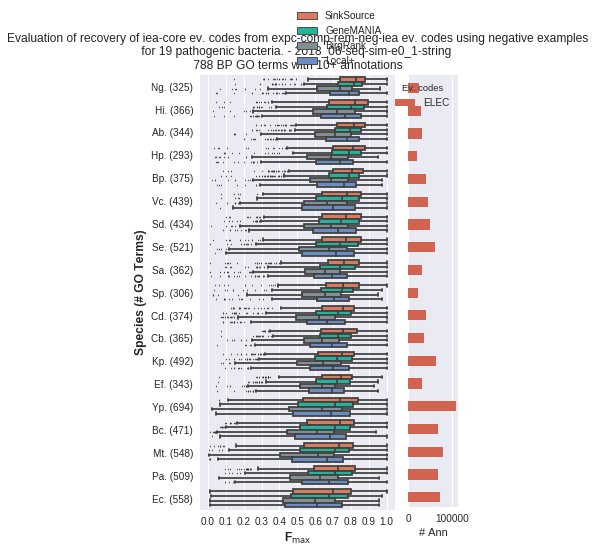

Creating plots for 'fmax'


/home/jeffl/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


File would be written to outputs/viz/eval-loso/expc-comp-rem-neg-iea-iea-core/2018_06-seq-sim-e0_1-string/10-1000-mf-4-use-neg-fmax-goterm-weight-a0_95-eps0_0-maxi10.pdf


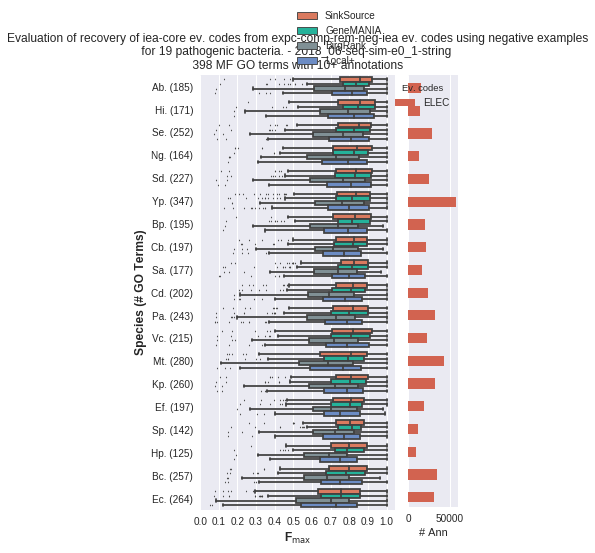

In [425]:
curr_h = "bp"
# curr_h = "mf"
# use this cell for creating the plots
for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results:
#     if version != "2018_06-seq-sim-e0_1-string" or h != curr_h:
#     if version != "2018_06-seq-sim-e0_1-string":
#         continue
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    sort_taxon_by_fmax = {}    
    if 'comp' in eval_ev_codes:
        ann_stats = ['COMP']
    elif 'iea' in eval_ev_codes:
        ann_stats = ['ELEC']
    else:
        ann_stats = ['EXPC']

#     for measure in measures:    
# #         plot_fmax_eval(cutoffs_data, cutoffs, out_dir, measure=measure, sort_taxon_by_fmax=sort_taxon_by_fmax)
#         plot_overview(cutoffs_data, cutoffs, out_dir, measure=measure)
    
    for measure in measures:
        print("Creating plots for '%s'" % (measure))
        if keep_ann == '':
            plot_fmax_eval(cutoffs_data, cutoffs, out_dir, measure=measure, sort_taxon_by_fmax=sort_taxon_by_fmax, ann_stats=ann_stats, 
                           write_to_file=False, for_pub=False,
#                            write_to_file=True, for_pub=True,
                          )
#         sig_results = eval_stat_sig(cutoffs_data, cutoffs, out_dir, measure=measure, sort_taxon_by_fmax=sort_taxon_by_fmax, alg1="genemania")
#         plot_overview(cutoffs_data, cutoffs, out_dir, measure=measure)

In [117]:
# use this cell for evaluating the statistical significance
for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results:
#     if version != "2018_06-seq-sim-e0_1-string" or h != curr_h:
#         continue
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    sort_taxon_by_fmax = {}    
    
    for measure in measures:
        sig_results = eval_stat_sig(cutoffs_data, cutoffs, out_dir, measure=measure, sort_taxon_by_fmax=sort_taxon_by_fmax, h=h,
#                                    alg1='genemania',
#                                     alg1='sinksource a1_0 ',
#                                     write_to_file=False,
                                   )
#         sig_results = eval_stat_sig(cutoffs_data, cutoffs, out_dir, measure=measure, sort_taxon_by_fmax=sort_taxon_by_fmax, alg1="genemania")

10 - 1000 annotations. Version: 2018_06-seq-sim-e0_1-string-700, 'expc' annotations
writing to outputs/viz/eval-loso/expc-core/2018_06-seq-sim-e0_1-string-700/10-1000-bp-sinksource-localplus-use-neg-fmax-a0_95-eps0_0-maxi10-sig.txt
#alg1	alg2	pval	Corrected p-value (x6)
sinksource	genemania	4.133e-01	2.480e+00
sinksource	birgrank	3.936e-01	2.362e+00
sinksource	localplus	5.735e-11	3.441e-10
genemania	birgrank	4.737e-01	2.842e+00
genemania	localplus	1.154e-10	6.925e-10
birgrank	localplus	7.544e-10	4.527e-09
Species	Alg1	Alg2	Raw p-value	Corrected p-value (x7)
E. coli	sinksource	localplus	2.64e-07	1.85e-06
M. tuberculosis	sinksource	localplus	7.84e-03	5.49e-02
P. aeruginosa	sinksource	localplus	2.46e-07	1.72e-06
S. typhimurium	sinksource	localplus	2.63e-01	1.84e+00
V. cholerae	sinksource	localplus	2.34e-02	1.64e-01
Y. pestis	sinksource	localplus	8.56e-05	5.99e-04
N. gonorrhoeae	sinksource	localplus	9.38e-01	6.57e+00

10 - 1000 annotations. Version: 2018_06-seq-sim-e0_1-string-700, 'expc' 

writing to outputs/viz/eval-loso/expc/2018_06-seq-sim-e0_1/../fig2-expc-compare-eval-fmax-boxplots-bp-0_95.pdf


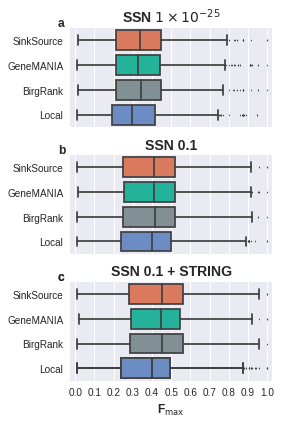

In [148]:
# code for generating boxplots comparing the median f-max of the different algorithms on different networks for the paper
version_name = {"2018_06-seq-sim-e1e-25": r"SSN $1 \times{}10^{-25}$", "2018_06-seq-sim-e0_1": "SSN 0.1",
               "2018_06-seq-sim-e1e-25-string": r"SSN $1 \times{}10^{-25}$ + STRING",  "2018_06-seq-sim-e0_1-string": "SSN 0.1 + STRING",
                "2018_06-seq-sim-e0_1-string-700": "SSN 0.1 + STRING"}
curr_h = 'bp'
# curr_h = 'mf'
plot_loc = {
    "2018_06-seq-sim-e1e-25": 0,
    "2018_06-seq-sim-e0_1": 1,
    "2018_06-seq-sim-e0_1-string-700": 2,
#     "2018_06-seq-sim-e1e-15": 1,
#     "2018_06-seq-sim-e1e-6":  2,
#     "2018_06-seq-sim-e0_1":   3,
#     "2018_06-seq-sim-e5":     4,
#     "2018_06-seq-sim-e20":    5,
#     "2018_06-seq-sim-e50":    6,
#     "2018_06-seq-sim-e1e-25-string": 2,
           }
# ev_code = "expc-rem-neg-comp-iea"
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
# letters = [['A', 'B'], ['C', 'D'], ['E', 'F'], ['G', 'H']]
# use this cell for creating the plots
fig, axes = plt.subplots(nrows=len(plot_loc), ncols=1, sharey=True, sharex=True,
                        figsize=(4,6))
# fig, axes = plt.subplots(nrows=len(plot_loc), ncols=2, sharey=True, sharex=True,figsize=(8,6))
for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results:
    if version not in plot_loc or h != curr_h:
        continue
#     print(version, ev_codes, eval_ev_codes, keep_ann, h)

    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    df_curr, _, _, _ = cutoffs_data[0]
#     i = 0 if "e1e-25" in version == "2018_06-seq-sim-e1e-25" else 1
    i = plot_loc[version]
#     j = 0 if h == 'bp' else 1
#     ax = axes[i][j]
    ax = axes[i]
    measure = measures[0]
#     title = r"%s - %s" % (version_name[version], h.upper())
    title = r"%s" % (version_name.get(version, version))
#     print(title)
    overview_plots(df_curr, measure, title=title,
                   xlabel=r'F$_{\mathrm{max}}$' if i == len(plot_loc)-1 else '', 
                   out_pref=None, ax=ax)
    ax.text(-0.09, -.7, letters[i], horizontalalignment='left', verticalalignment='center', fontsize=12, weight="bold")

ticks = np.arange(0,1.01,.1)
# ax.set_xticks(ticks, ["%0.1f"%x for x in ticks])
plt.setp(axes, xticks=ticks, xticklabels=["%0.1f"%x for x in ticks])
plt.tight_layout()
# plt.show()
# print(out_dir)
# the current dir has the version name
out_file = "%s/../fig2-expc-compare-eval-fmax-boxplots-%s-%s.pdf" % (out_dir, curr_h, ss_alpha)
print("writing to %s" % (out_file))
plt.savefig(out_file)
plt.show()
plt.close()

# Compute additional supporting statistics
- SinkSource vs Local
- Rank correlation of # of annotations vs median fmax
- P. aeruginosa vs M tuberculosis
- fmax vs % of annotations in left-out species

In [18]:
# get various p-values here
curr_h = "bp"
# version = "2018_06-seq-sim-e1e-25"
# key = (version, ev_codes, eval_ev_codes, keep_ann, curr_h)
# key = ('2018_06-seq-sim-e0_1-string-700', 'expc', '', '', 'bp')  # for comparing to local+. More accurate than comparing to SSN alone because the SSN alone doesn't have some of the pos examples which leads to an artificial improvement when evaluating
key = ('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'bp')
cutoffs_data, out_dir = ev_code_results[key]
df1, _, _, _ = cutoffs_data[0]
print(key)
# version = "2018_06-seq-sim-e0_1"
# key = (version, ev_codes, eval_ev_codes, keep_ann, curr_h)
key = ('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'bp')
cutoffs_data, out_dir = ev_code_results[key]
df2, species_exp_counts, _, _ = cutoffs_data[0]
print(key)
# print(df1.head())
# alg1, alg2 = ["SinkSource"]*2
# alg1, alg2 = ["GeneMANIA"]*2
# alg1, alg2 = ["BirgRank"]*2
alg1, alg2 = ('Local', 'SinkSource')
df1 = df1[df1['Algorithm'] == alg1]
df2 = df2[df2['Algorithm'] == alg2]
a1_fmax = df1['fmax']
a2_fmax = df2['fmax']
test_statistic, pval = mannwhitneyu(a2_fmax, a1_fmax, alternative='greater')
print("%s, %s: %0.1e" % (alg1, alg2, pval))

('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'bp')
('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'bp')
Local, SinkSource: 2.1e-09


In [19]:
# spearman's rank correlation of num annotations vs median fmax
df_counts = pd.DataFrame()
df_counts = pd.DataFrame([species_exp_counts]).T
df_counts.columns = ['EXP']
df_counts['#taxon'] = df_counts.index
df_counts.index = range(len(df_counts.index))
df_counts = pd.melt(df_counts, id_vars="#taxon", var_name="Ev. codes", value_name="# ann")
# df_counts['species'] = df_counts['#taxon'].apply(lambda x: species_labels[x])
taxon_med_fmax = df2.groupby('#taxon')['fmax'].median()

from scipy.stats import spearmanr
spearmanr(a=taxon_med_fmax, b=df_counts['# ann'])

SpearmanrResult(correlation=-0.9285714285714288, pvalue=0.0025194724037946874)

In [20]:
# P. aeruginosa vs M tuberculosis
pa = df2[df2['#taxon'] == 208964]['fmax']
mt = df2[df2['#taxon'] == 83332]['fmax']
mannwhitneyu(pa, mt, alternative='greater')

MannwhitneyuResult(statistic=33221.0, pvalue=1.1826249982453335e-08)

In [21]:
df2.head()

,#taxon,goid,fmax,avgp,auprc,auroc,# ann,Algorithm
0,208964,GO:0016043,0.0897,0.0456,0.0588,0.4115,36,SinkSource
1,208964,GO:0071840,0.0898,0.0459,0.0592,0.4148,36,SinkSource
2,208964,GO:0022607,0.0701,0.0284,0.0469,0.4275,26,SinkSource
3,208964,GO:0044764,0.1327,0.0674,0.0759,0.4266,55,SinkSource
4,208964,GO:0006928,0.2143,0.1606,0.1706,0.5931,47,SinkSource


/home/jeffl/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


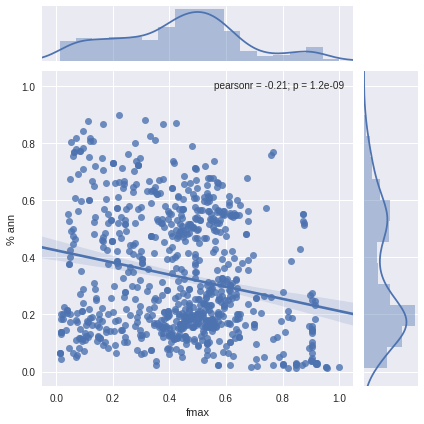

In [22]:
# fmax vs % of annotations in left-out species
# first load the # ann per GO term
summary_stats_file = "inputs/pos-neg/expc/pos-neg-10-summary-stats.tsv"
goterm_numann = pd.Series(utils.readDict(summary_stats_file, 1, 4))
# goterm_numann = goterm_numann[goterm_numann['GO term'].isin(df2['goid'])
# goterm_numann.head()
# now compute the % of ann in each left-out species
# df2 = df2.set_index('goid').sort_index()
# df2['% ann'] = df2.apply(lambda x: x['# ann'])
df2['% ann'] = df2.apply(lambda x: x['# ann'] / float(goterm_numann[x['goid']]), axis=1)
# df2.head()
# df2.plot.scatter('fmax', '% ann')
sns.jointplot(y='% ann', x='fmax', data=df2, kind="reg")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.show()

/home/jeffl/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


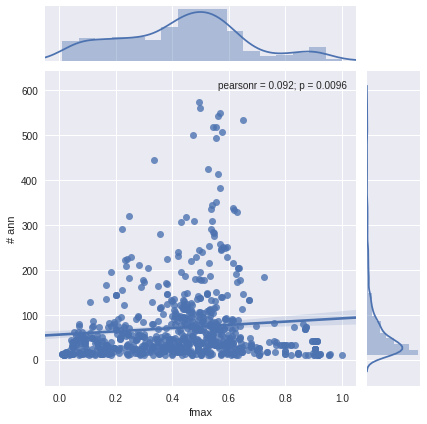

In [27]:
# fmax vs % of annotations in left-out species
# first load the # ann per GO term
summary_stats_file = "inputs/pos-neg/expc/pos-neg-10-summary-stats.tsv"
goterm_numann = pd.Series(utils.readDict(summary_stats_file, 1, 4))
# goterm_numann = goterm_numann[goterm_numann['GO term'].isin(df2['goid'])
# goterm_numann.head()
# now compute the % of ann in each left-out species
# df2 = df2.set_index('goid').sort_index()
# df2['% ann'] = df2.apply(lambda x: x['# ann'])
df2['% ann'] = df2.apply(lambda x: x['# ann'] / float(goterm_numann[x['goid']]), axis=1)
# df2.head()
# df2.plot.scatter('fmax', '% ann')
sns.jointplot(y='# ann', x='fmax', data=df2, kind="reg")
plt.xlim(-0.05, 1.05)
# plt.ylim(-0.05, 1.05)
plt.show()

In [117]:
spearmanr(df2['fmax'], df2['% ann'])

SpearmanrResult(correlation=-0.1638837145539488, pvalue=3.809968548261745e-06)

In [112]:
df2.head()

,#taxon,goid,fmax,avgp,auprc,auroc,# ann,Algorithm,% ann
0,208964,GO:0016043,0.0897,0.0456,0.0588,0.4115,36,SinkSource,0.115016
1,208964,GO:0071840,0.0898,0.0459,0.0592,0.4148,36,SinkSource,0.105572
2,208964,GO:0022607,0.0701,0.0284,0.0469,0.4275,26,SinkSource,0.109705
3,208964,GO:0044764,0.1327,0.0674,0.0759,0.4266,55,SinkSource,0.523810
4,208964,GO:0006928,0.2143,0.1606,0.1706,0.5931,47,SinkSource,0.573171


In [ ]:
# figure out which GO terms have the biggest difference for the first species H influezae (71421)
# also try Yersinia pestis (632)
cutoff1, cutoff2 = cutoffs[0]
df_curr = cutoffs_data[0][0]
print(version, ev_codes, eval_ev_codes, keep_ann, cutoff1, cutoff2)
# taxons = [93061, 632, 83333, 83332, 71421]
taxons = [71421, 93061, 83333]
for taxon in taxons:
    df_h_infl = df_curr[df_curr['#taxon'] == taxon]

    df_blast = df_h_infl[df_h_infl['Algorithm'] == "Blast Avg."]
    blast_scores = dict(zip(df_blast['goid'], df_blast['fmax']))
    df_ss = df_h_infl[df_h_infl['Algorithm'] == "SinkSource"]
    ss_scores = dict(zip(df_ss['goid'], df_ss['fmax']))

    # max_diff = ("goid", 0)
    goid_diffs = {}
    goid_diffs_abs = {}
    for goid in df_h_infl['goid']:
        if goid not in ss_scores and goid not in blast_scores:
#             print("WARNING: %s not in both SS and Blast Avg." % goid)
            continue
        if goid not in ss_scores:
            print("WARNING: %s not in SS" % goid)
            continue
        if goid not in blast_scores:
            print("WARNING: %s not in Blast Avg." % goid)
            continue
        goid_diff = ss_scores[goid] - blast_scores[goid]
        goid_diffs[goid] = goid_diff
        goid_diffs_abs[goid] = abs(goid_diff)
    #     print(goid_diff)
    #     if goid_diff > max_diff[1]:
    #         print(goid, goid_diff)
    #         max_diff = (goid, goid_diff)
    print("\t%d blast, %d SS, %d diffs" % (len(blast_scores), len(ss_scores), len(goid_diffs)))

    # also load the summary of the GO terms
    summary_file = "inputs/pos-neg/rem-neg-iea/pos-neg-50-summary-stats.tsv"
    df_summary = pd.read_csv(summary_file, sep='\t')
    goid_names = dict(zip(df_summary['GO term'], df_summary['GO term name']))
    goid_num_anno = dict(zip(df_summary['GO term'], df_summary['# positive examples']))
    goid_taxon_num_ann = dict(zip(df_h_infl['goid'], df_h_infl['# ann']))

    print("\nTop 5 difference in f-max:")
    print(''.join(["%s\t%s\t%s\t%s\n" % (
        g, goid_names[g], goid_num_anno[g], goid_diffs[g]) for g in sorted(
        goid_diffs, key=goid_diffs.get, reverse=True)[:5]]))

    # also write them to a file
    out_dir_stats = "%s/stats/" % (out_dir)
    utils.checkDir(out_dir_stats)
    out_file = "%s/%d-%d-%s-%s%s-fmax-diff-%s.tsv" % (
        out_dir_stats, cutoff1, cutoff2, h, 
        '-'.join(['sinksource', 'localplus']), with_neg, taxon)
    print("Writing to %s" % (out_file))
    with open(out_file, 'w') as out:
        out.write("#goid\tname\t# ann\t%s # ann\tlocalplus\tsinksource\tdiff\n" % (taxon))
        out.write(''.join(["%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (
            g, goid_names[g], goid_num_anno[g], goid_taxon_num_ann[g],
            blast_scores[g], ss_scores[g], goid_diffs[g]
        ) for g in sorted(goid_diffs, key=goid_diffs.get, reverse=True)]))

    df = pd.DataFrame({'Blast Avg. F-max': blast_scores, 'SinkSource F-max': ss_scores, 'diff': goid_diffs})
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,5))
    # df.plot.scatter(x='ss_scores', y='localplus', s='diff')
    df.plot.scatter(x='SinkSource F-max', y='Blast Avg. F-max', ax=ax1)
    ax1.plot([0,1], [0,1], '-')
#     plt.xlabel('SinkSource - Localplus Fmax')

    # make a histogram of the differences
#     for alg in algorithms:
#         df[df['Algorithm'] == alg_name[alg]][measure].hist(alpha=0.5)
    df["SinkSource > Blast Avg."] = df[df['diff'] > 0]['diff']
#     df['gt'].plot.hist(normed=True, ax=ax2)
    df['SinkSource < Blast Avg.'] = df[df['diff'] < 0]['diff']
#     df['lt'].plot.hist(normed=True, ax=ax2, color="#dba053")
    df['SinkSource = Blast Avg.'] = df[df['diff'] == 0]['diff']
#     df['eq'].plot.hist(normed=True, ax=ax2, color="#9b9b9b")
    curr_df = df[["SinkSource > Blast Avg.", 'SinkSource < Blast Avg.', 'SinkSource = Blast Avg.']]
    curr_df.plot.hist(bins=12, normed=True, stacked=True, alpha=0.8, ax=ax2, color=["#4e63ce", "#dba053", "#9b9b9b"])
#                     label=["SinkSource > Blast Avg.", "SinkSource < Blast Avg.", "SinkSource = Blast Avg."])
#     plt.legend(["SinkSource > Blast Avg.", "SinkSource < Blast Avg.", "SinkSource = Blast Avg."])
#     df['diff'].plot.hist(ax=ax2)
#     plt.xlabel('SinkSource - Localplus Fmax')
#     plt.title('%s, %s, %s-%s \n %s - %s' % (version, ev_codes, cutoff1, cutoff2, selected_species[str(taxon)], taxon))

    plt.suptitle('%s, %s, %s-%s \n %s - %s' % (version, ev_codes, cutoff1, cutoff2, selected_species[str(taxon)], taxon))
    plt.savefig(out_file.replace('.tsv', '.pdf'))
    plt.show()

('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 10, 1000, 'bp')
	787 blast, 787 SS, 787 diffs

Top 5 difference in f-max:
83333, GO:0022610	biological adhesion	52	0.4433
208964, GO:0044264	cellular polysaccharide metabolic process	139	0.3809
208964, GO:0005976	polysaccharide metabolic process	140	0.3809
83333, GO:0009312	oligosaccharide biosynthetic process	53	0.3711
208964, GO:0034637	cellular carbohydrate biosynthetic process	131	0.3499

Writing to outputs/viz/eval-loso/expc-core/2018_06-seq-sim-e0_1-string-700/stats//10-1000-sinksource-localplus-use-neg-bp-a0_95-fmax-diff.tsv


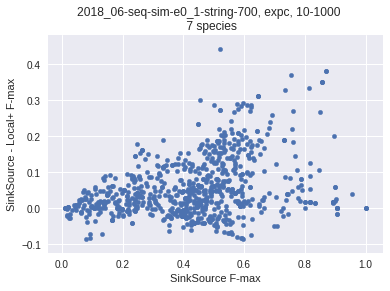

In [121]:
# figure out which GO terms have the biggest difference for all species
# plot a scatter plot of the differences across all GO terms
curr_h = "bp"
# curr_h = "mf"

for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results:
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    cutoff1, cutoff2 = cutoffs[0]
    df_curr = cutoffs_data[0][0]
#     if "e0_1" in version and h == 'bp':
    if "e0_1-string" in version and h == curr_h:
        print(version, ev_codes, eval_ev_codes, keep_ann, cutoff1, cutoff2, h)
        break

#     df_h_infl = df_curr[df_curr['#taxon'] == taxon]
df_h_infl = df_curr.copy()
# localplus = "Blast Avg."
localplus = "Local+"
sinksource = "SinkSource"
df_blast = df_h_infl[df_h_infl['Algorithm'] == localplus]
# key: taxon, goid tuple. Value: fmax
blast_scores = dict(zip(zip(df_blast['#taxon'], df_blast['goid']), df_blast['fmax']))
df_ss = df_h_infl[df_h_infl['Algorithm'] == sinksource]
ss_scores = dict(zip(zip(df_ss['#taxon'], df_ss['goid']), df_ss['fmax']))

goid_diffs = {}
for taxon, goid in df_h_infl[['#taxon', 'goid']].values:
    if (taxon, goid) not in ss_scores and goid not in blast_scores:
        print("WARNING: %s not in both SS and Blast Avg." % goid)
        continue
    if (taxon, goid) not in ss_scores:
        print("WARNING: %s not in SS" % goid)
        continue
    if (taxon, goid) not in blast_scores:
        print("WARNING: %s not in Blast Avg." % goid)
        continue
    goid_diff = ss_scores[(taxon, goid)] - blast_scores[(taxon, goid)]
#     goid_diff = (ss_scores[(taxon, goid)] - blast_scores[(taxon, goid)]) / float(blast_scores[(taxon, goid)])
    goid_diffs[(taxon, goid)] = goid_diff
print("\t%d blast, %d SS, %d diffs" % (len(blast_scores), len(ss_scores), len(goid_diffs)))

# also load the summary of the GO terms
summary_file = "inputs/pos-neg/%s/pos-neg-10-summary-stats.tsv" % (ev_codes)
df_summary = pd.read_csv(summary_file, sep='\t')
goid_names = dict(zip(df_summary['GO term'], df_summary['GO term name']))
goid_num_anno = dict(zip(df_summary['GO term'], df_summary['# positive examples']))
goid_taxon_num_ann = dict(zip(zip(df_blast['#taxon'], df_blast['goid']), df_blast['# ann']))

print("\nTop 5 difference in f-max:")
print(''.join(["%s, %s\t%s\t%s\t%s\n" % (
    t, g, goid_names[g], goid_num_anno[g], goid_diffs[t, g]) for t, g in sorted(
    goid_diffs, key=goid_diffs.get, reverse=True)[:5]]))

# also write them to a file
out_dir_stats = "%s/stats/" % (out_dir)
utils.checkDir(out_dir_stats)
out_file = "%s/%d-%d-%s%s-%s-a%s-fmax-diff.tsv" % (
    out_dir_stats, cutoff1, cutoff2, '-'.join(['sinksource', 'localplus']), with_neg, h, ss_alpha)
print("Writing to %s" % (out_file))
with open(out_file, 'w') as out:
    out.write("#taxon\tgoid\tname\t# ann\ttaxon # ann\tlocalplus\tsinksource\tdiff\n")
    out.write(''.join(["%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (
        t, g, goid_names[g], goid_num_anno[g], goid_taxon_num_ann[(t,g)],
        blast_scores[(t,g)], ss_scores[(t,g)], goid_diffs[(t,g)]
    ) for t, g in sorted(goid_diffs, key=goid_diffs.get, reverse=True)]))

df = pd.DataFrame({'%s F-max'%localplus: blast_scores, 'SinkSource F-max': ss_scores, 'SinkSource - %s F-max'%localplus: goid_diffs})
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,5))
# df.plot.scatter(x='ss_scores', y='localplus', s='diff')
df.plot.scatter(x='SinkSource F-max', y='SinkSource - %s F-max'%localplus) #, ax=ax1)
# ax1.plot([0,1], [0,1], '-')
#     plt.xlabel('SinkSource - Localplus Fmax')

# # make a histogram of the differences
# #     for alg in algorithms:
# #         df[df['Algorithm'] == alg_name[alg]][measure].hist(alpha=0.5)
# df["SinkSource > Blast Avg."] = df[df['diff'] > 0]['diff']
# #     df['gt'].plot.hist(normed=True, ax=ax2)
# df['SinkSource < Blast Avg.'] = df[df['diff'] < 0]['diff']
# #     df['lt'].plot.hist(normed=True, ax=ax2, color="#dba053")
# df['SinkSource = Blast Avg.'] = df[df['diff'] == 0]['diff']
# #     df['eq'].plot.hist(normed=True, ax=ax2, color="#9b9b9b")
# curr_df = df[["SinkSource > Blast Avg.", 'SinkSource < Blast Avg.', 'SinkSource = Blast Avg.']]
# curr_df.plot.hist(bins=12, normed=True, stacked=True, alpha=0.8, ax=ax2, color=["#4e63ce", "#dba053", "#9b9b9b"])
# #                     label=["SinkSource > Blast Avg.", "SinkSource < Blast Avg.", "SinkSource = Blast Avg."])
# #     plt.legend(["SinkSource > Blast Avg.", "SinkSource < Blast Avg.", "SinkSource = Blast Avg."])
# #     df['diff'].plot.hist(ax=ax2)
# #     plt.xlabel('SinkSource - Localplus Fmax')
# #     plt.title('%s, %s, %s-%s \n %s - %s' % (version, ev_codes, cutoff1, cutoff2, selected_species[str(taxon)], taxon))

plt.suptitle('%s, %s, %s-%s \n %d species' % (version, ev_codes, cutoff1, cutoff2, df_h_infl['#taxon'].nunique()))
# plt.savefig(out_file.replace('.tsv', '.pdf'))
plt.show()

writing to outputs/viz/eval-loso/expc-core/2018_06-seq-sim-e0_1-string-700/stats//10-1000-sinksource-localplus-use-neg-bp-a0_95-fmax-diff.pdf


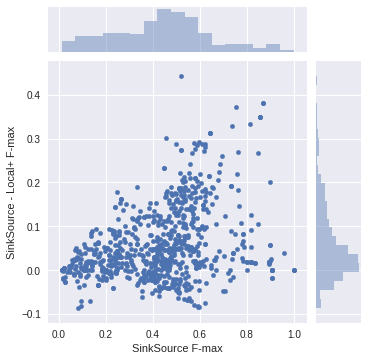

In [120]:
# fig, ax = plt.subplots(figsize=(4,4))
# sns.set(style="whitegrid")
grid = sns.jointplot(x='SinkSource F-max', y='SinkSource - %s F-max'%localplus, data=df,
              stat_func=None, joint_kws={"s": 20}, #marginal_kws=dict(bins=10),
             )
# plt.suptitle('%s, %s, %s-%s \n %d species' % (version, ev_codes, cutoff1, cutoff2, df_h_infl['#taxon'].nunique()))
# plt.tight_layout()
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
# grid.fig.set_figheight(4)
out_file2 = out_file.replace('.tsv', '.pdf')
# out_file2 = out_file.replace('.tsv', '-10bins.pdf')
print("writing to %s" % (out_file2))
plt.savefig(out_file2)
plt.show()
plt.close()
# switch back to defaults
# sns.set()

('2018_06-seq-sim-e1e-25-string', 'expc-comp-rem-neg-iea', '-core', '', 10, 1000)
	1105 blast, 1105 SS, 1105 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Dir outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea--core//stats doesn't exist. Creating it
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea--core//stats/2018_06-seq-sim-e1e-25-string-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


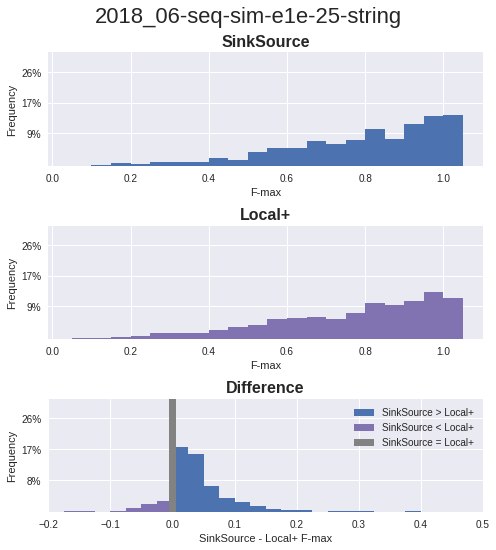

('2018_06-seq-sim-e1e-25', 'expc-comp-rem-neg-iea', '', '', 10, 1000)
	2265 blast, 2265 SS, 2265 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea-//stats/2018_06-seq-sim-e1e-25-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


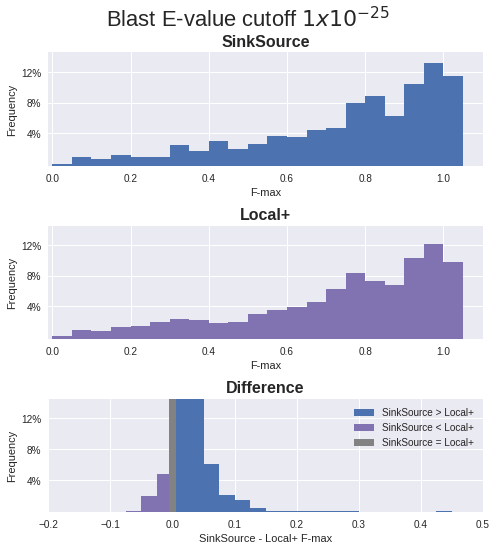

('2018_06-seq-sim-e0_1', 'expc-comp-rem-neg-iea', '', '', 10, 1000)
	2369 blast, 2369 SS, 2369 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea-//stats/2018_06-seq-sim-e0_1-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


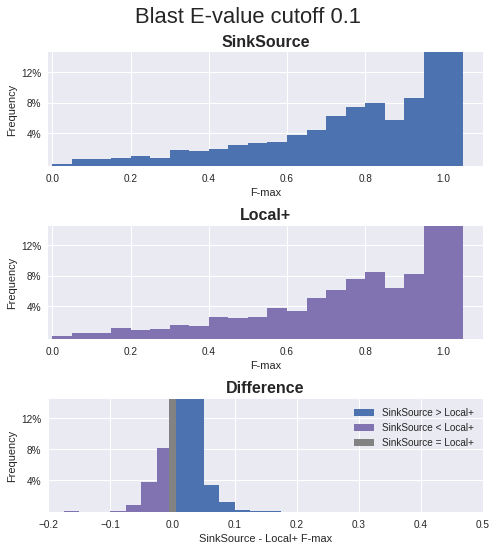

('2018_06-seq-sim-e0_1', 'expc-comp-rem-neg-iea', '', '', 10, 1000)
	1114 blast, 1114 SS, 1114 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea-//stats/2018_06-seq-sim-e0_1-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


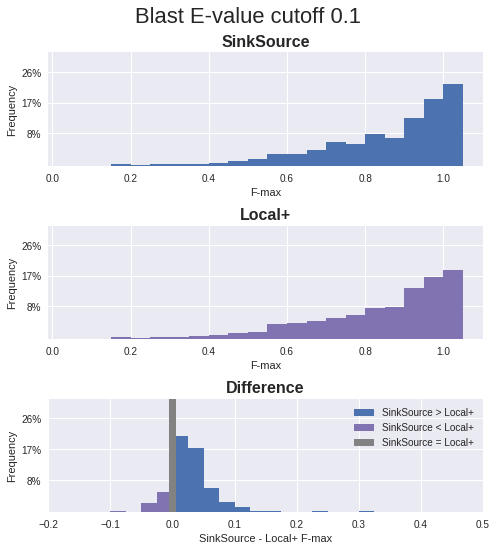

('2018_06-seq-sim-e1e-25', 'expc-comp-rem-neg-iea', '', '', 10, 1000)
	1074 blast, 1074 SS, 1074 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea-//stats/2018_06-seq-sim-e1e-25-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


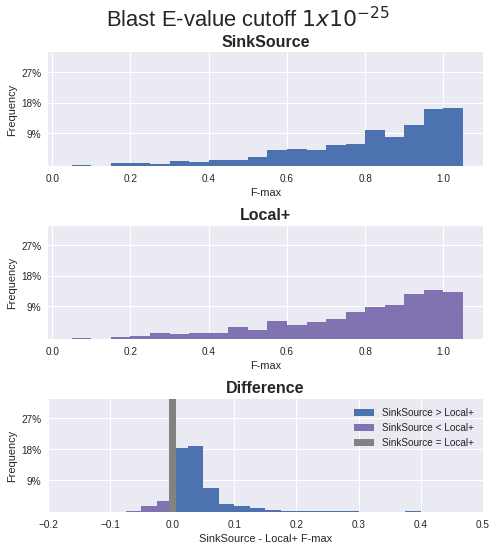

('2018_06-seq-sim-e1e-25-string', 'expc-comp-rem-neg-iea', '-core', '', 10, 1000)
	2348 blast, 2348 SS, 2348 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea--core//stats/2018_06-seq-sim-e1e-25-string-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


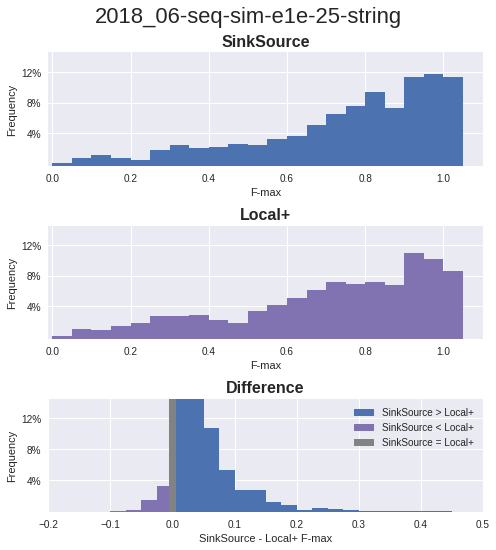

('2018_06-seq-sim-e0_1-string', 'expc-comp-rem-neg-iea', '-core', '', 10, 1000)
	2387 blast, 2387 SS, 2387 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea--core//stats/2018_06-seq-sim-e0_1-string-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


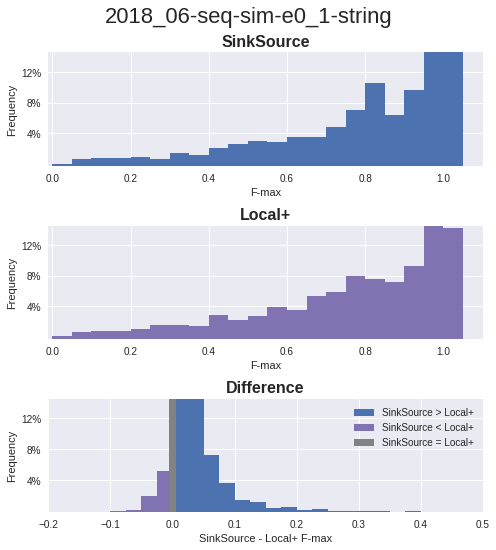

('2018_06-seq-sim-e0_1-string', 'expc-comp-rem-neg-iea', '-core', '', 10, 1000)
	1118 blast, 1118 SS, 1118 diffs
[100, 195, 290]
[100, 195, 290]
[97, 195, 290]
Writing to outputs/viz/eval-species-compare-eval/expc-comp-rem-neg-iea--core//stats/2018_06-seq-sim-e0_1-string-expc-comp-rem-neg-iea10-1000-sinksource-localplus-use-neg-comparison.pdf


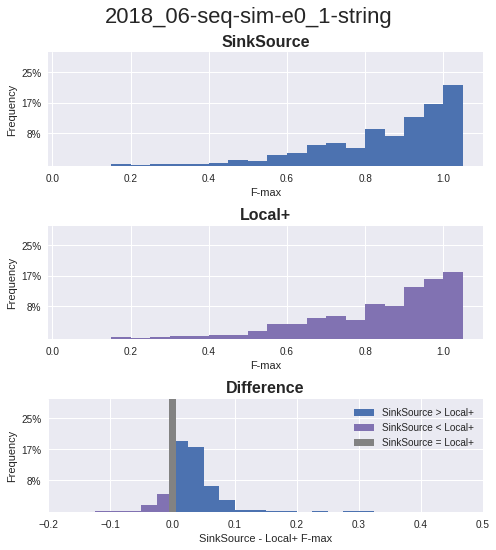

In [220]:
# make a histogram for each version to compare SS, BLAST and the Diff
version_title = {
    "2018_06-seq-sim-e1e-25": "Blast E-value cutoff $1x10^{-25}$",
    "2018_06-seq-sim-e1e-15": "Blast E-value cutoff $1x10^{-15}$",
    "2018_06-seq-sim-e1e-6": "Blast E-value cutoff $1x10^{-6}$",
    "2018_06-seq-sim-e0_1": "Blast E-value cutoff 0.1",
                }
localplus = "Local+"
sinksource = "SinkSource"
for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results:
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    cutoff1, cutoff2 = cutoffs[0]
    df_curr = cutoffs_data[0][0]
    print(version, ev_codes, eval_ev_codes, keep_ann, cutoff1, cutoff2)
#     print(df_curr.head())

#     df_h_infl = df_curr[df_curr['#taxon'] == taxon]
    df_h_infl = df_curr.copy()
    df_blast = df_h_infl[df_h_infl['Algorithm'] == localplus]
    # key: taxon, goid tuple. Value: fmax
    blast_scores = dict(zip(zip(df_blast['#taxon'], df_blast['goid']), df_blast['fmax']))
    df_ss = df_h_infl[df_h_infl['Algorithm'] == sinksource]
    ss_scores = dict(zip(zip(df_ss['#taxon'], df_ss['goid']), df_ss['fmax']))

    goid_diffs = {}
    for taxon, goid in df_h_infl[['#taxon', 'goid']].values:
        if (taxon, goid) not in ss_scores and goid not in blast_scores:
            print("WARNING: %s not in both SS and Blast Avg." % goid)
            continue
        if (taxon, goid) not in ss_scores:
            print("WARNING: %s not in SS" % goid)
            continue
        if (taxon, goid) not in blast_scores:
            print("WARNING: %s not in Blast Avg." % goid)
            continue
        goid_diff = ss_scores[(taxon, goid)] - blast_scores[(taxon, goid)]
    #     goid_diff = (ss_scores[(taxon, goid)] - blast_scores[(taxon, goid)]) / float(blast_scores[(taxon, goid)])
        goid_diffs[(taxon, goid)] = goid_diff
    print("\t%d blast, %d SS, %d diffs" % (len(blast_scores), len(ss_scores), len(goid_diffs)))

    df = pd.DataFrame({'blast-avg': blast_scores, 'sinksource': ss_scores, 'diff': goid_diffs})
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,8))
    # df.plot.scatter(x='ss_scores', y='localplus', s='diff')
    # keep the bins split evenly between 0 and 1 at an interval of 0.05
    bins = np.arange(0,1.06,.05)
    df['sinksource'].plot.hist(bins=bins, ax=ax1)
    df['blast-avg'].plot.hist(bins=bins, ax=ax2, color=sns.color_palette()[3])
#     weights = np.ones_like(df['sinksource'].values)/float(len(df['sinksource'].values))
#     ax1.hist(df['sinksource'].values, weights=weights, bins=bins)
#     weights = np.ones_like(df['blast-avg'].values)/float(len(df['blast-avg'].values))
#     ax2.hist(df['blast-avg'].values, weights=weights, bins=bins)
    for ax in (ax1, ax2):
        ax.set_xlabel("F-max")
        ax.set_xlim(-0.01,1.1)
        ax.set_ylim(0,350)
#         yticks = ax.get_yticks()[1:-1:2]
        yticks = [100, 195, 290]
# this is for the second set of counts
#         ax.set_ylim(0,1100)
#         yticks = [200, 400, 600, 800, 1000]
        print(yticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels(["%d%%"%(float(y) / float(len(goid_diffs))*100) for y in yticks])

        
    # set the titles
    for ax, title in ((ax1, sinksource), (ax2, localplus), (ax3, "Difference")):
        ax.set_title(title, fontsize=16, fontweight='bold')
    # include a small bin at 0
    bins = list(np.arange(-.5,0,.025)) + [-.005, .005] + list(np.arange(.025,1,.025))
#     print(bins)
#     df['diff'].plot.hist(bins=bins, ax=ax3)
#     weights = np.ones_like(df['diff'].values)/float(len(df['diff'].values))
#     ax3.hist(df['diff'].values, weights=weights, bins=bins, normed=False)
    # make a histogram of the differences
    #     for alg in algorithms:
    #         df[df['Algorithm'] == alg_name[alg]][measure].hist(alpha=0.5)
    gt = df[df['diff'] >= 0.005]['diff'].values
    #     df['gt'].plot.hist(normed=True, ax=ax2)
    lt = df[df['diff'] < -0.005]['diff'].values
    #     df['lt'].plot.hist(normed=True, ax=ax2, color="#dba053")
    eq = df[(df['diff'] >= -0.005) & (df['diff'] < 0.005)]['diff'].values
    #     df['eq'].plot.hist(normed=True, ax=ax2, color="#9b9b9b")
#     curr_df = df[["SinkSource > Blast Avg.", 'SinkSource < Blast Avg.', 'SinkSource = Blast Avg.']]
#     curr_df.plot.hist(bins=12, normed=True, stacked=True, alpha=0.8, ax=ax2, color=["#4e63ce", "#dba053", "#9b9b9b"])
    #                     label=["SinkSource > Blast Avg.", "SinkSource < Blast Avg.", "SinkSource = Blast Avg."])
    ax3.hist(gt, bins=bins, label="%s > %s"%(sinksource,localplus), color=sns.color_palette()[0])
    ax3.hist(lt, bins=bins, label="%s < %s"%(sinksource,localplus), color=sns.color_palette()[3])
    ax3.hist(eq, bins=bins, label="%s = %s"%(sinksource,localplus), color="#828282")
    ax3.set_xlim(-.2,.5)
    ax3.set_xlabel("%s - %s F-max"%(sinksource,localplus))
    ax3.set_ylabel("Frequency")
    ax3.set_ylim(0,350)
#     yticks = [97, 195, 290, 385, 480]
    yticks = [97, 195, 290]
#     ax3.set_ylim(0,1100)
#     yticks = [200, 400, 600, 800, 1000]
    print(yticks)
    ax3.set_yticks(yticks)
    ax3.set_yticklabels(["%d%%"%(float(y) / float(len(goid_diffs))*100) for y in yticks])
    legend = ax3.legend(shadow=True)
    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('#ffffff')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.suptitle('%s, %s, %s-%s \n %d species' % (version, ev_codes, cutoff1, cutoff2, df_h_infl['#taxon'].nunique()))
#     title = '%s, %s %s, %s-%s, %s' % (version, ev_codes, eval_ev_codes, cutoff1, cutoff2, keep_ann)
    if version in version_title:
        title = version_title[version]
    else:
        title = version
    plt.suptitle(r"%s"%title, fontsize=22)
    
    out_file = "%s/stats/%d-%d-%s-%s%s-a%s-comparison.pdf" % (
        out_dir, cutoff1, cutoff2, h 
        '-'.join(['sinksource', 'localplus']), with_neg, ss_alpha)
    utils.checkDir(os.path.dirname(out_file))
    print("Writing to %s" % (out_file))
#     plt.savefig(out_file)
    plt.show()
    plt.close()

In [490]:
# try using only the GO terms with > 0.05 difference
# cutoff1, cutoff2 = cutoffs[0]
# df_curr = cutoffs_data[0][0]
# print(version, ev_codes, eval_ev_codes, cutoff1, cutoff2)
for version, ev_codes, eval_ev_codes, keep_ann in ev_code_results:
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann)]
    cutoff1, cutoff2 = cutoffs[0]
    df_curr = cutoffs_data[0][0]
    print(version, ev_codes, eval_ev_codes, keep_ann, cutoff1, cutoff2)
    
    taxon_goids = defaultdict(set)
    min_diff = 0.0
    total_min = 0
    total_goids = 0
#     print("Minimum difference: %s" % (str(min_diff)))
    for taxon in df_curr['#taxon'].unique():
        df_h_infl = df_curr[df_curr['#taxon'] == taxon]

        df_blast = df_h_infl[df_h_infl['Algorithm'] == "Blast Avg."]
        blast_scores = dict(zip(df_blast['goid'], df_blast['fmax']))
    #     df_ss = df_h_infl[df_h_infl['Algorithm'] == "sinksource a1_0"]
        df_ss = df_h_infl[df_h_infl['Algorithm'] == "SinkSource"]
        ss_scores = dict(zip(df_ss['goid'], df_ss['fmax']))

        # max_diff = ("goid", 0)
        goid_diffs = {}
    #     goid_diffs_abs = {}
        for goid in df_h_infl['goid']:
            goid_diff = ss_scores[goid] - blast_scores[goid]
            goid_diffs[goid] = goid_diff
            if goid_diff > min_diff:
                taxon_goids[taxon].add(goid)

        num_above_cutoff = len(taxon_goids[taxon])
        total_min += num_above_cutoff
        total_goids += len(goid_diffs) 
        curr_perc = (num_above_cutoff / float(len(goid_diffs)))*100
    #     print("%0.1f%% (%d/%d) goids for taxon %s (%s)" % (curr_perc, num_above_cutoff, len(goid_diffs), taxon, selected_species[str(taxon)]))

    total_perc = (total_min / float(total_goids))*100
    print("Total: %0.1f%% (%d/%d) goids " % (total_perc, total_min, total_goids))


('2018_06-seq-sim-e1e-25', 'rem-neg-comp-iea', 'comp', '-keep-ann', 10, 100)
Total: 76.2% (1404/1842) goids 
('2018_06-seq-sim-e0_1', 'rem-neg-comp-iea', 'comp', '-keep-ann', 10, 100)
Total: 73.2% (1386/1893) goids 
('2018_06-seq-sim-e1e-15', 'rem-neg-comp-iea', 'comp', '-keep-ann', 10, 100)
Total: 76.6% (1428/1865) goids 
('2018_06-seq-sim-e1e-6', 'rem-neg-comp-iea', 'comp', '-keep-ann', 10, 100)
Total: 75.0% (1415/1887) goids 


In [23]:
# now combine the two
df['Network'] = version_name[versions[0]]
df2['Network'] = version_name[versions[1]]
df3 = pd.concat((df, df2))
df3 = df3.sort_values(by=['species', 'Network'])
print(df3.head())
print(df3.tail())

      #taxon        goid    fmax  # ann       species Network
1093  509170  GO:0065003  0.7273      8  A. baumannii  SeqSim
1094  509170  GO:0015992  0.7222     17  A. baumannii  SeqSim
1095  509170  GO:0006644  0.8163     24  A. baumannii  SeqSim
1096  509170  GO:0072528  0.6957     24  A. baumannii  SeqSim
1097  509170  GO:0043933  0.7273     11  A. baumannii  SeqSim
      #taxon        goid    fmax  # ann    species          Network
4921     632  GO:0006400  0.3355     69  Y. pestis  SeqSim + STRING
4922     632  GO:0010629  0.2410     52  Y. pestis  SeqSim + STRING
4923     632  GO:0015992  0.4706     58  Y. pestis  SeqSim + STRING
4924     632  GO:0090662  0.2797     76  Y. pestis  SeqSim + STRING
4925     632  GO:1901476  0.3756    103  Y. pestis  SeqSim + STRING


In [93]:
# make a table of median and median absolute deviation
# here's a quick function for median absolute deviation
def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

# curr_h = 'bp'
curr_h = 'mf'

for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results:
    if h != curr_h:
        continue
#     print(version, ev_codes, eval_ev_codes, keep_ann, h)

    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    df_curr, _, _, _ = cutoffs_data[0]
    
    for measure in measures:
#         print("measure: %s" % (measure))
        for alg in algorithms:
    #         print("\t%s: %0.3f \t\t(%d sp-goterm pairs)" % (alg, df_curr[df_curr['Algorithm'] == alg][measure].median(), len(df_curr[df_curr['Algorithm'] == alg][measure])))
            x = df_curr[df_curr['Algorithm'] == alg_name[alg]][measure]
            print("%s\t%s\t%s\t%s\t%0.3f\t%0.3f" % (version, ev_codes, h, alg_name[alg], x.median(), mad(x)))

2018_06-seq-sim-e20	expc-rem-neg-comp-iea	mf	SinkSource	0.593	0.148
2018_06-seq-sim-e20	expc-rem-neg-comp-iea	mf	GeneMANIA	nan	nan
2018_06-seq-sim-e20	expc-rem-neg-comp-iea	mf	BirgRank	0.500	0.167
2018_06-seq-sim-e20	expc-rem-neg-comp-iea	mf	Local+	0.545	0.152
2018_06-seq-sim-e1e-6	expc-rem-neg-comp-iea	mf	SinkSource	0.558	0.156
2018_06-seq-sim-e1e-6	expc-rem-neg-comp-iea	mf	GeneMANIA	0.554	0.149
2018_06-seq-sim-e1e-6	expc-rem-neg-comp-iea	mf	BirgRank	0.499	0.160
2018_06-seq-sim-e1e-6	expc-rem-neg-comp-iea	mf	Local+	0.525	0.167
2018_06-seq-sim-e50	expc-rem-neg-comp-iea	mf	SinkSource	0.600	0.144
2018_06-seq-sim-e50	expc-rem-neg-comp-iea	mf	GeneMANIA	0.585	0.144
2018_06-seq-sim-e50	expc-rem-neg-comp-iea	mf	BirgRank	0.501	0.168
2018_06-seq-sim-e50	expc-rem-neg-comp-iea	mf	Local+	0.539	0.145
2018_06-seq-sim-e1e-15	expc-rem-neg-comp-iea	mf	SinkSource	0.503	0.146
2018_06-seq-sim-e1e-15	expc-rem-neg-comp-iea	mf	GeneMANIA	0.504	0.155
2018_06-seq-sim-e1e-15	expc-rem-neg-comp-iea	mf	BirgRank	0.4

# Compare E-value cutoffs and STRING cutoffs

In [23]:
version_name = {
    "2018_06-seq-sim-e1e-25": r"$1 \times{}10^{-25}$", 
    "2018_06-seq-sim-e1e-15": r"$1 \times{}10^{-15}$",
    "2018_06-seq-sim-e1e-6":  r"$1 \times{}10^{-6}$",
    "2018_06-seq-sim-e0_1":   "0.1",
    "2018_06-seq-sim-e5":     "5",
    "2018_06-seq-sim-e20":    '20',
    "2018_06-seq-sim-e50":    '50', 
    "2018_06-seq-sim-e0_1-string": "400",
    "2018_06-seq-sim-e0_1-string-150": "150",
    "2018_06-seq-sim-e0_1-string-700": "700",
    "2018_06-seq-sim-e0_1-string-900": "900",
#     "2018_06-seq-sim-e0_1-string-swsn": "400 SWSN",
}

In [24]:
print(alg_name)

{'sinksourceplus': 'SinkSource+', 'birgrank': 'BirgRank', 'genemania': 'GeneMANIA', 'sinksource': 'SinkSource', 'local': 'Local-', 'sinksource-squeeze': 'SinkSource Squeeze', 'localplus': 'Local', 'aptrank': 'AptRank OneWay'}


In [25]:
# now make a line plot of all of the values
def plot_fmax_med(df, out_file=None, xlabel='', ylabel='', title='', version_order=None):
    fig, ax = plt.subplots()
    ax = sns.pointplot(x='cutoff', y='fmax', data=df, 
                 order=version_order, 
#                     hue='Algorithm', data=df_curr, orient='h')
                   hue='Algorithm', hue_order=[alg_name[a] for a in algorithms],
                  palette=my_palette, estimator=np.median,
                       ci=None, 
                       markers=["o", "s", "P", "v"],
#                        dodge=True, ci=95,
                 )
    plt.setp(ax.lines,linewidth=1)  # set lw for all lines of g axes

    if version_order is not None:
        ax.set_xticklabels([version_name[v] for v in version_order])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0.28, 0.575)
    plt.title(title)
#     plt.xticks(rotation=45)
    if out_file is not None:
        plt.savefig(out_file)
    plt.show()
    plt.close()

('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'bp')
('2018_06-seq-sim-e0_1-string-150', 'expc', '-core', '', 'bp')
('2018_06-seq-sim-e0_1-string', 'expc', '-core', '', 'bp')


/home/jeffl/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('2018_06-seq-sim-e0_1-string-900', 'expc', '-core', '', 'bp')
outputs/viz/eval-loso/expc-core/2018_06-seq-sim-e0_1-string-900/../compare-eval-cutoffs-bp-fmax-eps0_0-maxi10-gm2008-string.pdf


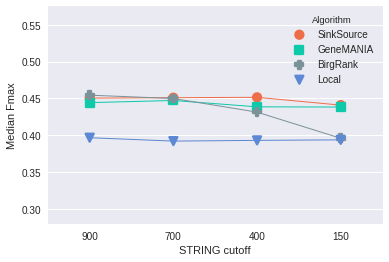

('2018_06-seq-sim-e0_1-string-150', 'expc', '-core', '', 'mf')
('2018_06-seq-sim-e0_1-string-700', 'expc', '-core', '', 'mf')
('2018_06-seq-sim-e0_1-string-900', 'expc', '-core', '', 'mf')
('2018_06-seq-sim-e0_1-string', 'expc', '-core', '', 'mf')
outputs/viz/eval-loso/expc-core/2018_06-seq-sim-e0_1-string/../compare-eval-cutoffs-mf-fmax-eps0_0-maxi10-gm2008-string.pdf


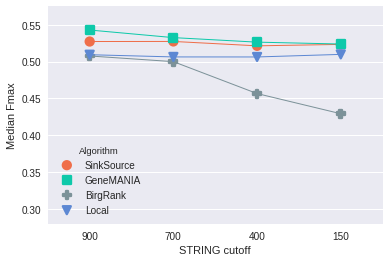

In [37]:
curr_algs = [alg_name[a] for a in algorithms]
# version_alg_fmax = defaultdict(dict)
# check if string is present
string_version = False
for version,_,_,_,_ in ev_code_results:
    if 'string' in version:
        string_version = True
        break
for curr_h in ['bp', 'mf']:
    df_all = pd.DataFrame()
#     version_alg_fmax = []
#     if string_version:
    if False:
        # get results for SWSN
        for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results_swsn:
            if h != curr_h:
                continue
            print(version, ev_codes, eval_ev_codes, keep_ann, h)
            cutoffs_data, out_dir = ev_code_results_swsn[(version, ev_codes, eval_ev_codes, keep_ann, h)]
            df_curr, _, _, _ = cutoffs_data[0]
            df_curr = df_curr[df_curr['Algorithm'].isin(curr_algs)]
            df_curr['cutoff'] = version+'-swsn'
            df_all = pd.concat([df_all, df_curr])
    for version, ev_codes, eval_ev_codes, keep_ann, h in ev_code_results:
    #     if version != '2018_06-seq-sim-e0_1-string' or h != curr_h:
        if h != curr_h:
            continue
        print(version, ev_codes, eval_ev_codes, keep_ann, h)
        cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
        df_curr, _, _, _ = cutoffs_data[0]
        df_curr = df_curr[df_curr['Algorithm'].isin(curr_algs)]
        df_curr['cutoff'] = version
        df_all = pd.concat([df_all, df_curr])
    #     for alg in algorithms:
    # #     #         print("\t%s: %0.3f \t\t(%d sp-goterm pairs)" % (alg, df_curr[df_curr['Algorithm'] == alg][measure].median(), len(df_curr[df_curr['Algorithm'] == alg][measure])))
    #         x = df_curr[df_curr['Algorithm'] == alg_name[alg]][measure]
    #         median_fmax = x.median()
    #         mad_fmax = mad(x)
    # #         version_alg_fmax[version][alg_name[alg]] = median_fmax
    # #         version_alg_fmax[alg_name[alg]].append([median_fmax, mad_fmax, version])
    #         version_alg_fmax.append([median_fmax, mad_fmax, alg_name[alg], version])
    
    # fix genemania for e20. For some reason, conjugate gradient is not running. 
    if string_version is False:
        print("fixing GeneMANIA")
        df_test = df_all[(df_all['Algorithm'] == 'GeneMANIA') & (df_all['cutoff'] == "2018_06-seq-sim-e5")]
        df_test['cutoff'] = "2018_06-seq-sim-e20"
        # df_test.head()
        df_all = pd.concat([df_all, df_test])

#     print(df_all.head())
    # df = pd.DataFrame(version_alg_fmax, columns=["median", "mad", 'algorithm', "version"])
    # df = pd.DataFrame(version_alg_fmax)
    version_order = ["2018_06-seq-sim-e1e-25", "2018_06-seq-sim-e1e-15", "2018_06-seq-sim-e1e-6", "2018_06-seq-sim-e0_1", "2018_06-seq-sim-e5", "2018_06-seq-sim-e20", "2018_06-seq-sim-e50"]
    xlabel='BLAST E-value cutoff'
    if string_version:
        version_order = ["2018_06-seq-sim-e0_1-string-900", "2018_06-seq-sim-e0_1-string-700", "2018_06-seq-sim-e0_1-string",  "2018_06-seq-sim-e0_1-string-150"]
        xlabel='STRING cutoff'
    out_file = "%s/../compare-eval-cutoffs-%s-fmax%s%s.pdf" % (
        out_dir, curr_h, ss_maxi, "-%sstring"%unweighted if string_version else "")
    # out_file = "%s/../compare-string-cutoffs-%s-fmax-swsn.pdf" % (out_dir, curr_h)
    print(out_file)
#     out_file = None
    plot_fmax_med(df_all, out_file=out_file, xlabel=xlabel, ylabel='Median Fmax', version_order=version_order)